In [1]:
import math
import os
import random
from pathlib import Path
from collections import defaultdict
from itertools import product


import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from dmba import plotDecisionTree, textDecisionTree

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse


## 1. K-Nearest Neighbors
KNeighborsClassifier 생성자 파라미터는 다음의 의미를 가진다.

  - n_neighobrs(default=5): 분류 시 고려할 인접 샘플 수

  - weights(default='uniform'): 'distance'로 설정하면, 분류할 때 인접한 샘플의 거리에 따라 다른 가중치 부여 (가까울수록 큰 가중치)

  - metric(default='minkowski'): 거리계산의 척도 (minkowski, euclidean, mahalanobis 등)

In [3]:
loan200 = pd.read_csv('data/loan200.csv')
 
predictors = ['payment_inc_ratio', 'dti']
outcome = 'outcome'


newloan = loan200.loc[0:0, predictors]
X = loan200.loc[1:, predictors]
y = loan200.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=20) # KNN 분류 
knn.fit(X, y)
knn.predict(newloan)
print(knn.predict_proba(newloan))

[[0.45 0.55]]


In [6]:
# kneighbors: 인접한 k개의 sample에 대해 거리, index를 반환
nbrs = knn.kneighbors(newloan)
nbrs

(array([[0.43787986, 0.88189485, 0.91751052, 1.65569826, 1.70611292,
         1.90596261, 2.08135622, 2.41682933, 2.44351029, 2.73230786,
         2.74245402, 2.86057968, 2.88767355, 2.99889915, 3.19912226,
         3.21420799, 3.36546794, 3.37976028, 3.462634  , 3.5414263 ]]),
 array([[ 34, 181, 180,  84,   8, 168,  20, 198,  76,  54, 140,  30,  65,
         162, 160, 111,  77,  45,  40, 138]], dtype=int64))

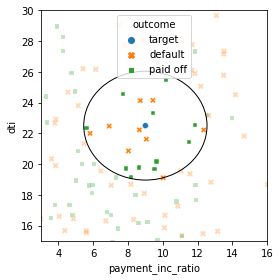

In [4]:
maxDistance = np.max(nbrs[0][0])

fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', data=loan200, alpha=0.3, ax=ax)
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', 
                data=pd.concat([loan200.loc[0:0, :], loan200.loc[nbrs[1][0] + 1,:]]), 
                ax=ax, legend=False)

# 가장 가까운 20개의 점들에 대한 경계선 
ellipse = Ellipse(xy=newloan.values[0], 
                  width=2 * maxDistance, height=2 * maxDistance,
                  edgecolor='black', fc='None', lw=1)
ax.add_patch(ellipse)
ax.set_xlim(3, 16)
ax.set_ylim(15, 30)

plt.tight_layout()
plt.show()

### 표준화 ( 정규화, Z-scores )

In [8]:
loan_data = pd.read_csv('data/loan_data.csv')
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)


predictors = ['payment_inc_ratio', 'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'

newloan = loan_data.loc[0:0, predictors]
print(newloan)
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

nbrs = knn.kneighbors(newloan)
print(X.iloc[nbrs[1][0], :])

   payment_inc_ratio  dti  revol_bal  revol_util
0             2.3932  1.0       1687         9.4
       payment_inc_ratio   dti  revol_bal  revol_util
35536            1.47212  1.46       1686        10.0
33651            3.38178  6.37       1688         8.4
25863            2.36303  1.39       1691         3.5
42953            1.28160  7.14       1684         3.9
43599            4.12244  8.98       1684         7.2


In [9]:

newloan = loan_data.loc[0:0, predictors]
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

scaler = preprocessing.StandardScaler()
scaler.fit(X * 1.0)

X_std = scaler.transform(X * 1.0)
newloan_std = scaler.transform(newloan * 1.0)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_std, y)

nbrs = knn.kneighbors(newloan_std)
print(X.iloc[nbrs[1][0], :])

       payment_inc_ratio   dti  revol_bal  revol_util
2080             2.61091  1.03       1218         9.7
1438             2.34343  0.51        278         9.9
30215            2.71200  1.34       1075         8.5
28542            2.39760  0.74       2917         7.4
44737            2.34309  1.37        488         7.2


## FE : feature Engine

count    45342.000000
mean         0.501104
std          0.128734
min          0.000000
25%          0.400000
50%          0.500000
75%          0.600000
max          0.950000
Name: borrower_score, dtype: float64


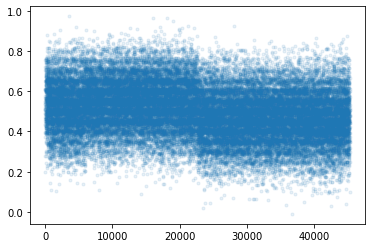

In [11]:
loan_data = pd.read_csv('data/loan_data.csv')
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)

predictors = ['dti', 'revol_bal', 'revol_util', 'open_acc', 
              'delinq_2yrs_zero', 'pub_rec_zero']
outcome = 'outcome'

X = loan_data[predictors]
y = loan_data[outcome]

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
plt.scatter(range(len(X)), [bs + random.gauss(0, 0.015) for bs in knn.predict_proba(X)[:,0]], 
            alpha=0.1, marker='.')
knn.predict_proba(X)[:, 0]

loan_data['borrower_score'] = knn.predict_proba(X)[:, 0]
print(loan_data['borrower_score'].describe())

# 트리 모델
## 예제

In [12]:
loan3000 = pd.read_csv('data/loan3000.csv')

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_tree = DecisionTreeClassifier(random_state=1, criterion='entropy',
                                   min_impurity_decrease=0.003)
loan_tree.fit(X, y)
plotDecisionTree(loan_tree, feature_names=predictors, class_names=loan_tree.classes_)

'You need to install pydotplus to visualize decision trees'